In [1]:
import numpy as np
from autograd.scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as plt
import itertools as iter
import cmath
%matplotlib inline

In [2]:
# Machine parameters

#Dictionary - one of the data structures used in Python 
#Name of_dictionary = {'name of variable': value, "nameof2ndvariable": value2}
mach_mc = {"rs": 0.009, "rr": 0.007, "lh": 4.14, "ls": 4.21, "lr": 4.21, "tmech":509.6}

mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

#mach_my = {"rs": 0.016, "rr": 0.05, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

print(mach_mb["rs"])

#defining parmeters for a T-equivalent circuit
def mach_para(dict):
    rs = dict["rs"]
    rr = dict["rr"]
    lh = dict["lh"]
    ls = dict["ls"]
    lr = dict["lr"]
    tmech = dict["tmech"]
    sig= 1-(lh*lh)/(lr*ls)
    ks=lh/ls
    kr=lh/ls
    ts = ls/rr
    tr = lr/rr
    rk = lr - lh*ks
    sk = lh - lr/ks
    siglr = sig*lr
    
    return rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk

0.0185


In [3]:
def DFIG_dynamic(X, t, paraDFIG):
    x0 = X[0] #ira
    x1 = X[1] #irb
    x2  = X[2] #isa
    x3  = X[3] #isb
    wr = X[4]
    
    vra,vrb,ml,rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk,psisa,psisb = paraDFIG
    
    me = ks*(psisa*x1 - psisb*x0) 
    diradt = 1/rk*vra - rr/rk*x0 - wr*lr/rk*x1 + lh/(ts*rk)*x2 -wr*lh/rk*x3
    dirbdt = 1/rk*vrb - rr/rk*x1 + wr*lr/rk*x0 + lh/(ts*rk)*x3 +wr*lh/rk*x2 - kr/rk
    disadt = 1/sk*vra - rr/sk*x0 - wr*lr/sk*x1 + rs/(kr*sk)*x2 -wr*lh/sk*x3
    disbdt = 1/sk*vrb - rr/sk*x1 + wr*lr/sk*x0 + rs/(kr*sk)*x3 +wr*lh/sk*x2 - 1/(kr*sk)
    dwdt = (1/tmech)*(me - ml)
    return [diradt, dirbdt, disadt, disbdt, dwdt]

In [4]:
def stator_model(X,t,paramsmodel):
    lh,ls,isa,isb,ira,irb =paramsmodel
    
    psisa = ls*isa + lh*ira
    psisb = ls*isb + lh*isb
    return [psisa, psisb]

In [5]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]

    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

In [6]:
tend = 4#s
tinc = 3.183098861837907e-05
rt = np.arange(0,tend,tinc)
#Solution variables and control variab;es
u = np.zeros((len(rt),2)) #array for the voltage - u[0][0] - vralpha(0) u[0][1] - vrbeta(0)
mla = np.zeros(len(rt))  #load torque array
soln = np.zeros((len(rt),5)) #array to store the solution values 
solm = np.zeros((len(rt),2))
print(np.shape(u))

(125664, 2)


In [7]:
#generating voltages
#defining the voltage and torque steps
w_R = 2*np.pi*50
a = 0.5
for ii, item in enumerate(rt):
    if(item < 3e-3):
        u[ii] = [0,0]
        mla[ii] = 0.5
    elif(item <= 10e-3):
        u[ii] = [a*np.cos(a*w_R*item), a*np.sin(a*w_R*item)] #vbyf = constant acheived
        mla[ii] = 0.3
    else:
        u[ii] = [a*np.cos(a*w_R*item), a*np.sin(a*w_R*item)]
        mla[ii] = 0.2
#set machine parameters
rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk= mach_para(mach_ma)


In [8]:
T_s = 3.183098861837907e-05#512e-6#sampling time
########-----------------------------------
V_LL = 400#V
Vpnpeak = np.sqrt(2)*V_LL/np.sqrt(3)
I_LL = 10.4#A
V_DC = np.sqrt(2)*V_LL#V Peak value of line to line voltage
print("V_DC", V_DC)
T_eq = 1.5*T_s
# T_eq = T_s
#Normalized time constant
tau_eq = T_eq*w_R
k_c = V_DC/(2*Vpnpeak)
#
rk = - rs*ks - lr/(sig*ks)*(1-0.2*sig*tr)
tk = -rk * ks/(siglr)
k_is = 1/rk
k_im = k_c*1/rk
ac = 4.0
T_i = tk
T_i = tau_eq*ac**2
k_pi = tk/(0.8*ac*k_im*tau_eq)
print(ac,tk,tau_eq)
kp = 5.0
Ti = 0.24
Kparams = [kp,Ti]
#Kparams = [k_pi,T_i]
Kparams2 = [k_pi,T_i, -1.0,1.0]
print(k_pi, T_i, k_im)
rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk = mach_para(mach_ma)
#----------------------------

V_DC 565.685424949238
4.0 529.8315373987897 0.015
-544926.175758564 0.24 -0.020256242992504066


In [9]:
ura = np.zeros(len(rt))
urb = np.zeros(len(rt))
sol1 = np.zeros((len(rt),5))
sol2 = np.zeros((len(rt),2))
FCangle = np.zeros(len(rt))
# Field coordinate currents
cosdelta = np.zeros(len(rt))
sindelta = np.zeros(len(rt))
ird = np.zeros(len(rt))
irq = np.zeros(len(rt))
urd = np.zeros(len(rt))
urq = np.zeros(len(rt))
eid = np.zeros(len(rt))
eiq = np.zeros(len(rt))

#Creating reference values for isd and isq
irdrefval = 1/lh
irdref = np.zeros(len(rt))
irqref = np.zeros(len(rt))

irqref1 = 0
irqref2 = 0.5
irqref3 = -0.35
for ii, item in enumerate(rt):
    irdref[ii] = irdrefval
    if (item >= 15e-3):
        irqref[ii] = irqref3
    elif(item >= 5e-3):
        irqref[ii]= irqref2
    else:
        irqref[ii]=irqref1


psisd = np.zeros(len(rt))
psisq = np.zeros(len(rt))

mL = 0.0
me = np.zeros(len(rt))

rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk = mach_para(mach_ma)

In [10]:
ws = 0.4
#Initialize
X0 = [0.3,0.0,1.0,0.0, ws] #setting the inital conditions 
X0m = [1.0,0] 
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3
psisa = 1.0;
psisb = 1.0
for ii, item in enumerate(rt):
    if ii > 0:
        eid[ii] = irdref[ii-1] - ird[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        urd[ii] = PIcon(PIed, urd[ii-1], w_R*tinc,Kparams) #+ ws*sig*ls*isq[ii-1]
#         usd[ii] = PIconwithLim(PIed,usd[ii-1],tinc,Kparams2)
        eiq[ii] = irqref[ii-1] - irq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        urq[ii] = PIcon(PIeq, urq[ii-1], w_R*tinc,Kparams) #- ws*sig*ls*isd[ii-1]
#         usq[ii] = PIconwithLim(PIeq,usq[ii-1],tinc,Kparams2)
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
    #vector control transformation 
    ura[ii] = urd[ii-1]*cosdelta[ii-1] - urq[ii-1]*sindelta[ii-1]
    urb[ii] = urq[ii-1]*cosdelta[ii-1] + urd[ii-1]*sindelta[ii-1]
    #------------------------------------------------------------------------------------
    #Model of the induction motor full
    params = [ura[ii],urb[ii],0.2, rs,rr,lh,ls,lr,sig,ks,kr,ts,tr,tmech,siglr,rk,sk,sol2[ii][0],sol2[ii][1]] #desired frequency , voltage components, load torque
    #call odeint(dydt, Initial condition, [0,tinc], parameters)
    solx = odeint(DFIG_dynamic,X0, [0,w_R*tinc], args = (params,), atol = abserr, rtol = relerr)
    X0 = solx[-1] #
    sol1[ii] = solx[-1] #

    #estimator uses only the variables that I can measure
    paramsmodel = [lh,ls,sol1[ii,2],sol1[ii,3],sol1[ii,0],sol1[ii,1]]
    soly = odeint(stator_model,X0m, [0,w_R*tinc], args = (paramsmodel,), atol = abserr, rtol = relerr)
    X0m = soly[-1]
    sol2[ii] = soly[-1]
    #----------------------------------------
    psircomp = complex(sol2[ii][0], sol2[ii][1])
    FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
    cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
    sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
    #Coordinate transformation 
    #Convert stator coordinate current to field coordinates
    ird[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
    irq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psisd[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
    psisq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]

    
ira = sol1[:, 0]
irb = sol1[:, 1]
pssa = sol1[:, 2]
pssb = sol1[:, 3]
w = sol1[:, 4]
psiradash = sol2[:,0]
psirbdash = sol2[:,1]

#me1 = ks*(pssa*irb - pssb*ira)

(-1.2, 1.2)

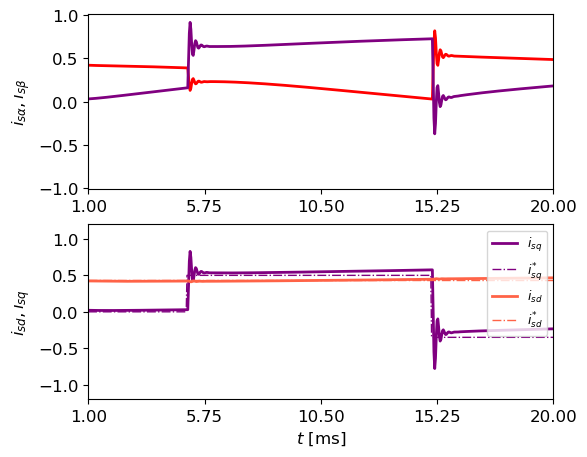

In [11]:
plt.figure(531, figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.plot(rt/1e-3,  ira, 'r',lw =2) 
plt.plot(rt/1e-3,irb ,'purple' ,lw =2)
# plt.plot(rt, psra, 'skyblue')
t1w = 1e-3#np.pi*2*45
t2w = 20e-3#tend#7e-3#np.pi*2*60
plt.xlim(t1w/1e-3,t2w/1e-3)
plt.ylim(-1.01,1.01)
plt.xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
plt.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# plt.xticks(np.linspace(t1w,t2w,5))
ax1 = plt.subplot(2,1,2)
ax1.plot(rt/1e-3, irq, 'purple', lw =2, label = r'$i_{sq}$')
# ax1.plot(rt/1e-3, eiq, 'r', lw =1, label = r'$e_{sq}$')
ax1.plot(rt/1e-3,irqref,ls="-.", c= 'purple', lw =1, label = r'$i^{*}_{sq}$')
ax1 = plt.subplot(2,1,2)
ax1.plot(rt/1e-3, ird, 'tomato', lw =2, label = r'$i_{sd}$')
ax1.plot(rt/1e-3,irdref,ls="-.", c= 'tomato', lw =1, label = r'$i^{*}_{sd}$')
ax1.plot(rt/1e-3,psisd, 'magenta', lw=2)
ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
ax1.set_xlabel(r'$t$ [ms]')

plt.rcParams['legend.fontsize']=9
ax1.legend(loc = 'upper right')

# ax1.axhline(0, c = 'k')
#pl.axhline(-1.0)

# t1w = 0#np.pi*2*45
# t2w = tend#np.pi*2*60
ax1.set_xlim(t1w/1e-3,t2w/1e-3)
ax1.set_xticks(np.linspace(t1w/1e-3,t2w/1e-3,5))
# ax1.set_yticks(np.linspace(-0.5,1.0,4))
ax1.set_ylim(-1.2,1.2)
# ax2.set_ylim(0,3.14)
#Change name
# plt.savefig(dirfig2 + "FOCcurrentsvst2.pdf", bbox_inches = 'tight', transparent = True)

# plt.figure(5341, figsize = (4,2.85))
# plt.plot(rt/1e-3, irq, 'crimson', lw =2, label = r'$i_{sq}$')
# # ax1.plot(rt/1e-3, eiq, 'r', lw =1, label = r'$e_{sq}$')
# plt.plot(rt/1e-3,irqref,ls="-.", c= 'r', lw =1, label = r'$i^{*}_{sq}$')
# t1w = 4.8e-3#np.pi*2*45
# t2w = 7e-3#tend#7e-3#np.pi*2*60
# plt.xlim(t1w/1e-3,t2w/1e-3)
# plt.ylim(-0.1)
# plt.ylabel(r'$i^{*}_{sq}, \i_{sq}$' )
# plt.xlabel(r'$t$ [ms]')
# plt.legend(loc = 'lower right', fontsize = 10)
# plt.minorticks_on()
# plt.grid(which = 'major', c = 'skyblue', lw = 0.5)
# plt.grid(which = 'minor', c = 'grey', lw = 0.2)
# plt.axvline(5.0512, c ='k', lw = 1.0)
# plt.show()